### Imports

In [1]:
import tensorflow as tf

from keras.applications import vgg16
from keras.optimizers import adam_v2
from keras.losses import sparse_categorical_crossentropy
from keras.layers import Dense, Flatten

import matplotlib.pyplot as plt

### Constants

In [48]:
# Get train and test data from folder.
TRAIN_DIRECTORY = "data/AFD/AFD（Animal Face Dataset)/face images/Saimiri sciureus"
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32  # This is keras default
NUM_CHANNELS = 3
IMAGE_DIMENSIONS = (IMG_HEIGHT, IMG_WIDTH)
SEED = 123

NUM_EPOCHS = 20
LEARNING_RATE = 0.001

VALIDATION_SPLIT = 0.2  # 20% reserved for validation

### Load Data

In [55]:
print("Training:")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIRECTORY,
    validation_split=VALIDATION_SPLIT,
    subset='training',
    seed=SEED,
    image_size=IMAGE_DIMENSIONS,
    batch_size=BATCH_SIZE,

)
print()

print("Validation:")
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIRECTORY,
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    seed=SEED,
    image_size=IMAGE_DIMENSIONS,
    batch_size=BATCH_SIZE,
)

number_classes = len(
    train_ds.class_names) + 2  # 1 for false-positives (not a monkey), 1 for previously unseen individuals

print()
print("Total classes including negative and false-positive:", number_classes)

Training:
Found 252 files belonging to 44 classes.
Using 202 files for training.

Validation:
Found 252 files belonging to 44 classes.
Using 50 files for validation.

Total classes including negative and false-positive: 46


#### Configure the dataset for performance

In [56]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Pre-Process Data for VGG

In [57]:
for image_batch, labels_batch in train_ds:
    # in-place pre-processing of images
    updated_image_batch = vgg16.preprocess_input(image_batch)
    train_ds


TypeError: 'BatchDataset' object is not subscriptable

In [44]:
# See here for implementation https://keras.io/api/applications/vgg/#vgg16-function
model = vgg16.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS),
    pooling='avg',  # Global average pooling applied.
    classes=number_classes,
)

# Add dense layers to perform prediction
model.layers.append(Flatten())
model.layers.append(Dense(units=4096, activation="relu"))
model.layers.append(Dense(units=4096, activation="relu"))
model.layers.append(Dense(units=number_classes, activation="softmax"))

In [45]:
optimizer = adam_v2.Adam(learning_rate=LEARNING_RATE)
print("Learning rate:", LEARNING_RATE)

# sparse as Y values are stored as integers (0-42), rather than one-hot encoded (i.e. 3 class, [1,0,0], [0,1,0], [0,0,1])
loss = sparse_categorical_crossentropy

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

NameError: name 'LEARNING_RATE' is not defined

In [28]:
hist = model.fit(
    x=train_ds,  # y is obtained from this x
    epochs=NUM_EPOCHS,
    verbose=True,
    validation_data=val_ds)

Epoch 1/20
7/7 [==============================] - 52s 7s/step - loss: 14.3368 - accuracy: 0.0198 - val_loss: 15.8075 - val_accuracy: 0.0400
Epoch 2/20
7/7 [==============================] - 51s 7s/step - loss: 14.8723 - accuracy: 0.0396 - val_loss: 15.8075 - val_accuracy: 0.0400

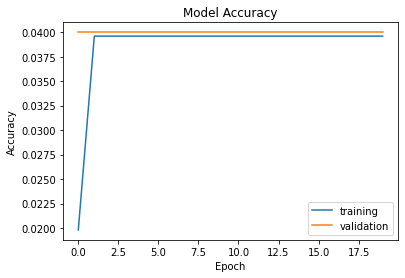

In [41]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["training", "validation"])
plt.show()

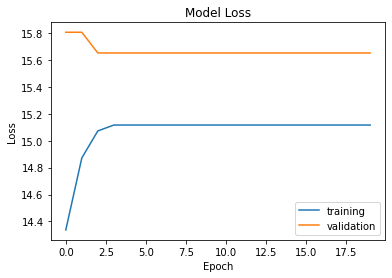

In [42]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["training", "validation"])
plt.show()